In [1]:
scpileup_dir = "/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/cond0/MT/cellr_True/numread_200/"
af_f = "/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/cond0/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv"
mt_ref_fa = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"
name = "cond0"

#minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/
min_cells=10
min_reads=50
topn=0
het_thresh=0.001 
min_het_cells=10
het_count_thresh=5
bq_thresh=20
log=""



In [3]:
import glob
from os.path import join, dirname
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
from pandarallel import pandarallel
import numpy as np
from numpanpar import parallel_df as pardf
from Bio import SeqIO
import click
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
mpl.use('Agg')
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from src.utils.data_io import load_sc_pileup, load_and_filter_nt_pileups



fig_utils from mplh


In [4]:
from tqdm.notebook import tqdm

In [5]:

def fill_af_by_cell_loop(cell_df, coverage_dir, type="coverage"):
    """ Cell series where indices are the positions and columns are variant info.

    Loads in the A/C/G/T/coverage files, then loops through the
    positions and fills in the alternative allele AF.
    """

    for cell, cell_series in cell_df.iterrows():
        cell_nucs = dict()
        for n in ["A", "C", "G", "T", "coverage"]:
            if not os.path.exists(join(coverage_dir, "CB_" + cell + "." + n + ".txt")): #it only has the rev strand
                print(f"{n} not found for {cell}")
                continue
            cell_nucs[n] = pd.read_csv(
                join(coverage_dir, "CB_" + cell + "." + n + ".txt"),
                header=None)
            if n == "coverage":
                cell_nucs[n].columns = ["Position", "Cell", "Coverage"]
            else:
                cell_nucs[n].columns = ["Position", "Cell", "Coverage",
                                        "BQ"]
            cell_nucs[n] = cell_nucs[n].set_index("Position",
                                                  drop=False)
            cell_nucs[n]["Cell"] = cell_nucs[n]["Cell"].apply(
                lambda x: x.replace(".bam", ""))
            cell_nucs[n]["Coverage"] = cell_nucs[n]["Coverage"].fillna(
                0)
        # Loop through each position and calculate AF frequency,
        # where the position is the last character of the index name
        for ind, val in (cell_series.iteritems()):
            pos = int(ind[:-1])
            n = ind[-1]
            # curr_nuc_df = nt_cov_dict[n]
            if n not in cell_nucs or "coverage" not in cell_nucs:
                continue
            if pos in cell_nucs[n].index.values:
                if type == 'coverage':
                    cell_df.loc[cell, ind] = cell_nucs[n].loc[pos][
                                                 "Coverage"] / \
                                             cell_nucs["coverage"].loc[pos][
                                                 "Coverage"]
                elif type=="BQ":
                    cell_df.loc[cell, ind] = cell_nucs[n].loc[pos,"BQ"]
                else:
                    print("Type variable not recognized")

                if cell_df.loc[cell, ind] > 1:
                    print("Above 1", ind, pos)
            else:
                cell_df.loc[cell, ind] = 0
    return cell_df



In [6]:
def create_af_by_cell(af, cell_names, coverage_dir, num_proc):
    af_by_cell = pd.DataFrame(
        index=af.apply(lambda x: (str(x.name) + x["Nucleotide"]),
                       axis=1).values, columns=cell_names)
    af_by_cell.columns = list(map(lambda x: x.replace("CB_", "").replace(".bam",""),
                             af_by_cell.columns))
    af_by_cell = pardf(af_by_cell.transpose(),
                            fill_af_by_cell_loop,
                            func_args=(coverage_dir,),
                            num_processes=num_proc)
    af_by_cell = af_by_cell.loc[:,(af_by_cell>0).any(axis=0)]

    bq_by_cell = af_by_cell.copy() #Placeholder for shape
    bq_by_cell = pardf(bq_by_cell.transpose(),
                            fill_af_by_cell_loop,
                            func_args=(coverage_dir,),
                            num_processes=num_proc)

    bq_by_cell = bq_by_cell.loc[:,(bq_by_cell>0).any(axis=0)]
    return af_by_cell, bq_by_cell


In [7]:
def extract_af_pileup_v02(af, pileup_dir, cell_names):
    """

    Loads in the A/C/G/T/coverage files, then loops through the
    positions and fills in the alternative allele AF.
    """
    af_nt_pileup = {}
    for n, curr_af in af.groupby("Nucleotide"):
        print(n)
        var_pos_to_keep = curr_af["Position"].unique()
        curr_f = glob.glob(os.path.join(pileup_dir, f"*.{n}.strands.txt"))[0]
        df = pd.read_csv(curr_f, header=None)
        # Only take the Forward reads since it is the one to compare against the reference
        if len(df.columns) > 4:
            df.columns = ["Position", "Cell", "+ Coverage", "+ BQ",
                          "- Coverage", "- BQ"]  # df = df.iloc[:, :4]
            df["Coverage"] = df["+ Coverage"] + df["- Coverage"]
            # Average bq by weighted sum
            df["BQ"] = df["+ BQ"]*(df["+ Coverage"])/(df["Coverage"]) + df["- BQ"]*(df["- Coverage"])/(df["Coverage"])
            #df["BQ"] = (df["+ BQ"] + df["- BQ"])/2
        else:
            df.columns = ["Position", "Cell", "Coverage", "BQ"]
        df["Cell"] = df["Cell"].apply(lambda x: x.replace(".bam", ""))

        #########
        df = df[df["Cell"].isin(cell_names)]
        df = df[df["Position"].isin(var_pos_to_keep)]
        df["NT"] = n
        #########
        af_nt_pileup[n] = df

    cov = load_sc_pileup(
        os.path.join(pileup_dir, f"*.coverage.strands.txt"))
    cov = cov[cov["Cell"].isin(cell_names)]
    cov = cov[cov["Position"].isin(af["Position"])]
    af_sparse_df = pd.concat(af_nt_pileup.values(), axis=0)
    af_sparse_df = af_sparse_df.rename({"Coverage": "Allele Depth"},
                                       axis=1)

    cov_ad = pd.merge(af_sparse_df, cov, how='inner',
                      on=["Position", "Cell"])
    cov_ad["ID"] = cov_ad.apply(
        lambda x: (str(x["Position"]) + x["NT"]), axis=1)

    cov_ad["AF"] = cov_ad["Allele Depth"] / cov_ad["Coverage"]
    return cov_ad


def get_gaussian_thresh(df, prob_thresh=0.9, to_plot=False, f_save=""):
    cell_depth = np.log10(df)
    cell_inds = cell_depth.index
    X = cell_depth.values.reshape(-1, 1)
    gm = GaussianMixture(n_components=2, random_state=0).fit(X)
    probs = gm.predict_proba(X)
    max_clust = gm.means_[:, 0].argmax()
    gauss_cells_to_keep = np.flatnonzero(
        probs[:, max_clust] > prob_thresh)
    gauss_cell_labels = cell_inds[gauss_cells_to_keep]
    min_clust = (-1 * max_clust) + 1  # 1 or 0
    gauss_cells_to_remove = np.flatnonzero(
        probs[:, min_clust] > prob_thresh)
    gauss_cell_remove_labels = cell_inds[gauss_cells_to_remove]

    if to_plot:
        f, ax = plt.subplots()
        ax.hist(cell_depth)
        ax.hist(cell_depth.loc[gauss_cell_labels], color='g', alpha=0.8)
        ax.hist(cell_depth.loc[gauss_cell_remove_labels], color='r',
                alpha=0.5)
        plt.title(
            "Cell total coverage across MT. Filtering out low coverage")
        if not (f_save == ""):
            plt.savefig(f_save.replace(".png", "") + ".png", dpi=300)
    print('gauss labels', len(gauss_cell_labels))
    if len(gauss_cell_labels) < 0.5 * cell_depth.shape[0]:
        print('Removing the low confident cells')
        # Throw away the low values instead
        gauss_cell_labels = np.delete(cell_inds.values, gauss_cells_to_remove, axis=0) #cell_inds[~(gauss_cells_to_remove)]
        print('low conf', len(gauss_cells_to_remove))
    return gauss_cell_labels, gm


def filter_positions_cells(sc_coverage, topN=500, min_cells=100, min_reads=100, f_save=""):
    """ Filters cells and counts based on depth

    :param sc_coverage:
    :param topN:
    :param min_cells:
    :param min_reads:
    :param coverage_thresh:
    :return:
    """
    print("Filtering cells")
    print("topN", topN)
    if topN == -1 or topN == 0: ## Keep them all
        topCells = sc_coverage.groupby("Cell").sum()["Coverage"].sort_values(ascending=False)

    else:
        topCells = sc_coverage.groupby("Cell").sum()["Coverage"].sort_values(ascending=False)[:topN]
    print(topCells.shape)
    print(topCells.head())
    cell_filter = topCells.index.values

    #above_thresh = sc_coverage.groupby("Cell").sum()["Coverage"]>coverage_thresh
    #above_thresh = above_thresh[above_thresh==True].index
    print('running gaussian threshold')
    cell_gauss, _ = get_gaussian_thresh(topCells, prob_thresh=0.9, to_plot=False, f_save=f_save)
    print('cells after gauss thresh', len(cell_gauss))

    sc_coverage = sc_coverage.loc[sc_coverage["Cell"].isin(cell_filter)]
    # Only positions with minimum number of reads overall in the cell
    sc_coverage = sc_coverage.loc[sc_coverage["Cell"].isin(cell_gauss)]

    # Only positions with minimum number of reads at the position
    pos_counts_filter = (sc_coverage.groupby("Position").apply(
        lambda x: (x['Coverage'] >= min_reads).sum())) >= min_cells
    pos_counts_filter = pos_counts_filter[pos_counts_filter==True].index.values

    cell_filter = list(set(cell_gauss).intersection(set(cell_filter)))
    print(f"Number of positions to keep : {len(pos_counts_filter)}")
    print(f"Number of cells to keep : {len(cell_filter)}")
    return pos_counts_filter, cell_filter


def filter_allele_cells(af_by_cell, het_thresh=0, min_het_cells=0):
    """ Filter the variants based on counts or AF thresholds.

    :param af_by_cell:
    :type af_by_cell: pd.DataFrame or np.array of floats or ints
    :param het_thresh:
    :param min_het_cells:
    :return:
    """
    het_filt = (af_by_cell > het_thresh).sum(axis=0) > min_het_cells
    het_filt = het_filt[het_filt].index
    print(f'Positions that pass het filter: {len(het_filt)}')
    return het_filt


def get_nt_bq(concat_dir, cell_inds, nt_pos):
    """ For each position, get the counts and average quality for each nt.
    :param concat_dir:
    :return:
    """
    nucs = ["A", "C", "G", "T"]
    # Make a |nucleotide|-by-MT dataframe to get  overall allele frequencies for each position
    nt_df = pd.DataFrame(index=nt_pos, columns=nucs,
                         dtype=int)
    bq_df = pd.DataFrame(index=nt_pos, columns=nucs, dtype=int)

    # # Dictionary of coverage per cell
    cells = dict()
    nt_pileup = load_and_filter_nt_pileups(concat_dir,
                                           cell_inds, nt_pos,
                                           out_d=None, name=None, sum_cov=True,
                                           input_suffix=".strands.txt")
    for n in nt_pileup:
        df = nt_pileup[n]
        cells[n] = set(df["Cell"].values)
        pos = df.groupby("Position")
        nt_df.loc[:, n] = pos["Coverage"].agg("sum")
        bq_df.loc[:, n] = pos["BQ"].agg("mean")
        # nt_cov_dict[n] = df

    nt_df = nt_df.fillna(0)
    bq_df = bq_df.fillna(0)
    cell_names = set()
    for n in cells:
        cell_names=cell_names.union(cells[n])

    return nt_df, bq_df, cell_names


In [8]:
def extract_af_v02(nt_df, bq_df, ref_fasta):
    mt_fasta_sequence = list(SeqIO.parse(mt_ref_fa, "fasta"))
    af_inds = []
    for ind, val in nt_df.iterrows():
        curr_ref = str(mt_fasta_sequence[0].seq).upper()[ind - 1]
        curr_nts = val[val!=0].index
        curr_nts = set(curr_nts) - set([curr_ref])
        af_inds.extend([f"{ind}>{x}" for x in curr_nts])

    af = pd.DataFrame(index=af_inds, columns=["Position", "Nucleotide", "AF", "Reference",
                               "Alternative BQ", "Depth"])
    no_alt_count = 0
    for ind, val in tqdm(nt_df.iterrows()):
        if ind > len(str(mt_fasta_sequence[0].seq)) - 1:
            break
        # Get the reference nucleotide from the fasta file
        curr_ref = str(mt_fasta_sequence[0].seq).upper()[ind - 1]

        if curr_ref not in nt_df.columns.values: # 'N'
            print(f'Not using {curr_ref}')
            continue
        curr_nts = list(val[val!=0].index.values)
        if curr_ref in val.index:
            curr_nts.remove(curr_ref)
            val = val.drop(curr_ref)

        val.index =  [f"{ind}>{x}" for x in curr_nts] 
        curr_af = val/val.sum()
        #curr_nts = set(val[val!=0].index.values) - set([curr_ref])
        curr_inds = curr_af.index
        curr_bq = bq_df.loc[ind]
        curr_bq.index =  [f"{ind}>{x}" for x in curr_bq.index] 
        curr_bq = curr_bq.loc[curr_inds]

        af.loc[curr_inds, "Position"] = ind
        af.loc[curr_inds, "AF"] = curr_af
        af.loc[curr_inds, "Nucleotide"] = curr_nts
        af.loc[curr_inds, "Reference"] = curr_ref
        af.loc[curr_inds, "Alternative BQ"] = curr_bq
        af.loc[curr_inds, "Depth"] = val.sum() #(val[alt_nuc]+val[curr_ref]) # jan26_2021

    # Create variant ID name (e.g. 18A-position 18 variant A)
    print(f"number of positions: {len(af)}")
    print('af head')
    print(af.head())
    print(af.shape)
    logging.info(f'# of positions with no variant detected: {no_alt_count}')
    af = af.dropna()
    print(af.shape)
    af["ID"] = af.index

    af.head()
    return af



In [9]:
def plot_init(dp_by_cell, out_d=None):
    f_init, ax = plt.subplots(nrows=3, ncols=1)
    sns.heatmap(np.log2(dp_by_cell.iloc[:min(len(dp_by_cell), 500)] + 1), ax=ax[0])
    ax[0].set_title("Log2 depth\nLowest 100 depth cells")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    if len(dp_by_cell) > 5100:
        sns.heatmap(np.log2(dp_by_cell.iloc[5000:5100] + 1), ax=ax[1])
        ax[1].set_title("Middle 1000 depth cells")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
    sns.heatmap(np.log2(dp_by_cell.iloc[-100:] + 1), ax=ax[2])
    ax[2].set_title("Highest 100 depth cells")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    plt.subplots_adjust(hspace=1)
    #plt.show()
    if out_d is not None:
        f_init.savefig(join(out_d, "initial_cell_depth.png"), dpi=300)
        #plt.close(f_init)
    return f_init



In [10]:
# 0. Create stats df, and figure
stats = pd.DataFrame(
    columns=["# Cells", "# Positions", "# Variants"])

out_d = os.path.dirname(af_f)
if not os.path.exists(out_d):
    logging.warning(f'{out_d} not here. Creatign directory')
    os.mkdir(out_d)
# 1. Load the MTPos pileup matrix, take the average of the +/- strands
sc_coverage = load_sc_pileup(
    join(scpileup_dir, "*.coverage.strands.txt"))

stats = stats.append(pd.DataFrame([[len(
    sc_coverage["Cell"].unique()), max(sc_coverage["Position"]),
                                    0]],
                                  columns=["# Cells", "# Positions",
                                           "# Variants"],
                                  index=["Initial 10x barcodes"]))
logging.info('stats -\n{}'.format(stats.to_string()))
dp_by_cell = sc_coverage.pivot(index="Cell", columns="Position",
                               values="Coverage").fillna(0)
logging.info('sorting depth')
dp_by_cell = dp_by_cell.loc[dp_by_cell.sum(axis=1).sort_values().index]

plot_init(dp_by_cell, out_d=out_d)


# 2. Filter A: top cells by coverage, minimum coverage, minimum number of cells and certain number of reads
pos_counts_filter, cell_filter = filter_positions_cells(sc_coverage,
                                                        topN=topn,
                                                        min_cells=min_cells,
                                                        min_reads=min_reads, f_save=join(out_d, "gauss_hist.png"))

stats = stats.append(
    pd.DataFrame([[len(cell_filter), len(pos_counts_filter), 0]],
                 columns=["# Cells", "# Positions", "# Variants"],
                 index=[
                     f"Depth thresh: topN {topn} min_cells {min_cells} min_reads {min_reads}"]))
logging.info('stats -\n{}'.format(stats.to_string()))
if len(cell_filter) == 0 or len(pos_counts_filter) == 0:
    logging.warning("Nothing passes the filter.")


   0                                1      2
0  1  Cell0donor0condition0cloned0cl3    8.0
1  2  Cell0donor0condition0cloned0cl3  512.0
2  3  Cell0donor0condition0cloned0cl3   32.0
3  4  Cell0donor0condition0cloned0cl3   64.0
4  5  Cell0donor0condition0cloned0cl3   16.0
Filtering cells
topN 0
(600,)
Cell
Cell118donor1condition0cloned1cl1    2184677
Cell230donor1condition0cloned1cl1    2184020
Cell6donor1condition0cloned1cl4      2183802
Cell228donor0condition0cloned0cl2    2183352
Cell2donor0condition0cloned0cl2      2182888
Name: Coverage, dtype: int64
running gaussian threshold
gauss labels 240
Removing the low confident cells
low conf 56
cells after gauss thresh 544
Number of positions to keep : 16568
Number of cells to keep : 544


In [11]:

# 3. Get the nt position info from filtered cells and variants.
nt_df, bq_df, cell_names = get_nt_bq(scpileup_dir,
                                     cell_inds=cell_filter,
                                     nt_pos=pos_counts_filter)

Loading pileups
num cols 6
num cols 6
num cols 6
num cols 6


In [12]:
# 4. Get the highest alt allele, store in af, which is the filtered AF Pos-by-[AF, BQ] df
af = extract_af_v02(nt_df, bq_df, mt_ref_fa)


0it [00:00, ?it/s]

number of positions: 49704
af head
    Position Nucleotide        AF Reference Alternative BQ Depth
1>C        1          C  0.315789         G           37.0    76
1>A        1          A  0.355263         G           37.0    76
1>T        1          T  0.328947         G           37.0    76
2>C        2          C  0.346154         A           37.0    78
2>G        2          G  0.346154         A           37.0    78
(49704, 6)
(49701, 6)


A
C
G
T
   0                                1      2
0  1  Cell0donor0condition0cloned0cl3    8.0
1  2  Cell0donor0condition0cloned0cl3  512.0
2  3  Cell0donor0condition0cloned0cl3   32.0
3  4  Cell0donor0condition0cloned0cl3   64.0
4  5  Cell0donor0condition0cloned0cl3   16.0


<AxesSubplot:xlabel='ID', ylabel='Cell'>

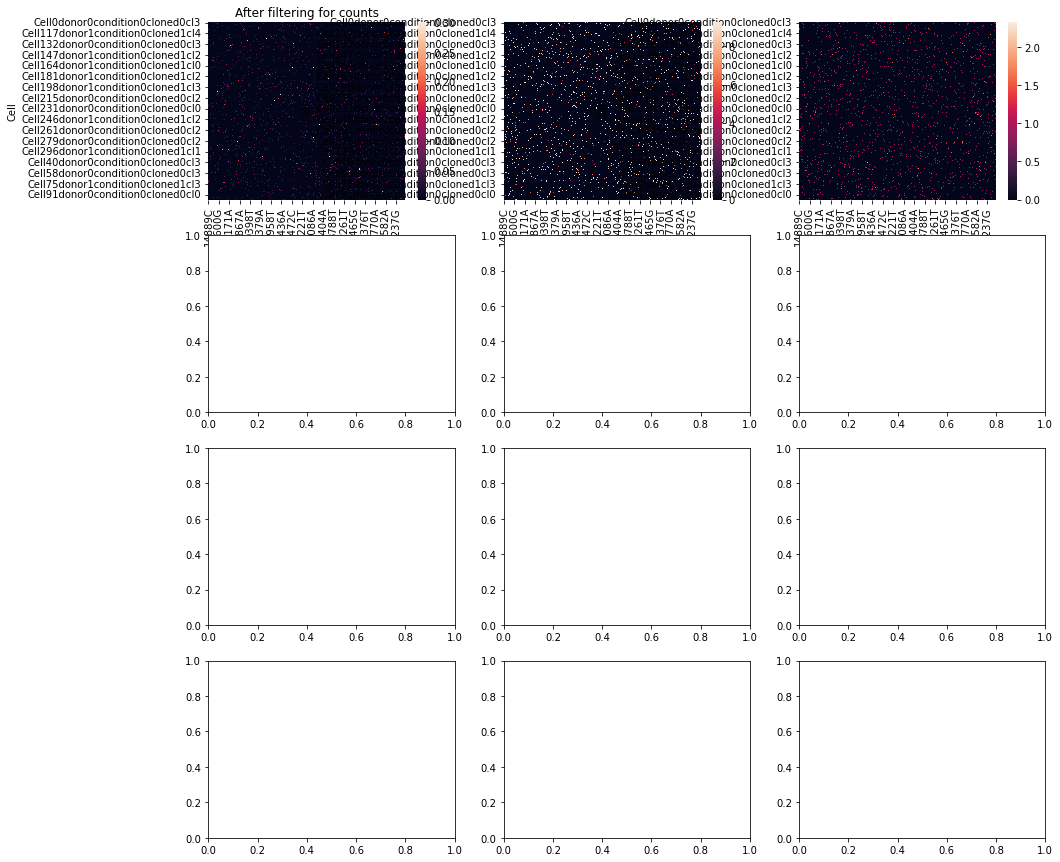

In [14]:
%matplotlib inline
# 5. Now that we called our alternate alleles, put them in
#    cell-allele sparse form (no 0s), extracting from the sparse
#    nucleotide pileups
cov_ad = extract_af_pileup_v02(af, scpileup_dir, cell_names)

af_by_cell = cov_ad.pivot(index="Cell", columns="ID",
                          values="AF").fillna(0)

cov_ad = cov_ad[(cov_ad["ID"].isin(af_by_cell.columns)) & (cov_ad["Cell"].isin(af_by_cell.index))]
ad_by_cell = cov_ad.pivot(index="Cell", columns="ID",
                          values="Allele Depth").fillna(0)
depth_by_cell = cov_ad.pivot(index="Cell",
                             columns="ID",
                             values="Coverage").fillna(0)
f_heat, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
if af_by_cell.shape[0]>1000:
    logging.info('sampling for the heatmap')
    samp_inds = np.random.choice(np.array(af_by_cell.shape[0]), size=1000, replace=False)
else:
    samp_inds = np.arange(af_by_cell.shape[0])

if af_by_cell.shape[1]>1000:
    logging.info('sampling for the heatmap')
    samp_cols = np.random.choice(np.array(af_by_cell.shape[1]), size=1000, replace=False)
else:
    samp_cols = np.arange(af_by_cell.shape[1])    

sns.heatmap(np.sqrt(af_by_cell.iloc[samp_inds, samp_cols]), vmin=0, vmax=0.3, ax=ax[0, 0])
ax[0,0].set_title("After filtering for counts")
sns.heatmap(np.log2(depth_by_cell.iloc[samp_inds, samp_cols] + 1), ax=ax[0, 1])
sns.heatmap(np.log2(ad_by_cell.iloc[samp_inds, samp_cols] + 1), ax=ax[0, 2])


In [15]:
def df_sample(df):
    if df.shape[0]>1000:
        samp_inds = np.random.choice(np.array(df.shape[0]), size=1000, replace=False)
    else:
        samp_inds = np.arange(df.shape[0])
    if df.shape[1]>1000:
        samp_cols = np.random.choice(np.array(df.shape[1]), size=1000, replace=False)
    else:
        samp_cols = np.arange(df.shape[1]) 
    return samp_inds, samp_cols

In [16]:
%matplotlib inline
# 6. FILTER B: minimum cells w heterozygous AF minimum
het_filt = filter_allele_cells(af_by_cell, het_thresh,
                               min_het_cells=min_het_cells)
af_by_cell = af_by_cell[het_filt]
ad_by_cell = ad_by_cell[het_filt]

stats = stats.append(
    pd.DataFrame([[af_by_cell.shape[0], af_by_cell.shape[1], 0]],
                 columns=["# Cells", "# Positions", "# Variants"],
                 index=[
                     f"min het af {het_thresh} min. het cells {min_het_cells}"]))
samp_inds, samp_cols = df_sample(af_by_cell)

sns.heatmap(np.sqrt(af_by_cell.iloc[samp_inds,samp_cols]), vmin=0, vmax=0.3, ax=ax[1, 0])
ax[1,0].set_title("After filtering het AF")
# Create depth-by-cell
depth_by_cell = cov_ad[(cov_ad["ID"].isin(af_by_cell.columns)) & (
    cov_ad["Cell"].isin(af_by_cell.index))].pivot(index="Cell",
                                                  columns="ID",
                                                  values="Coverage").fillna(0)

sns.heatmap(np.log2(depth_by_cell.iloc[samp_inds,samp_cols] + 1), ax=ax[1, 1])
sns.heatmap(np.log2(ad_by_cell.iloc[samp_inds,samp_cols] + 1), ax=ax[1, 2])


Positions that pass het filter: 49512


<AxesSubplot:xlabel='ID', ylabel='Cell'>

In [17]:
%matplotlib inline
# 7. FILTER C: by minimum cells w heterozygous count minimum
het_filt = filter_allele_cells(ad_by_cell, het_count_thresh,
                               min_het_cells=min_het_cells)
af_by_cell = af_by_cell[het_filt]
ad_by_cell = ad_by_cell[het_filt]

stats = stats.append(
    pd.DataFrame([[af_by_cell.shape[0], af_by_cell.shape[1], 0]],
                 columns=["# Cells", "# Positions", "# Variants"],
                 index=[
                     f"min het count {het_count_thresh} min. het cells {min_het_cells}"]))
logging.info('stats -\n{}'.format(stats.to_string()))
samp_inds, samp_cols = df_sample(af_by_cell)

sns.heatmap(np.sqrt(af_by_cell.iloc[samp_inds, samp_cols]), vmin=0, vmax=0.3, ax=ax[2,0])
ax[2,0].set_title("After filtering het Count")

# Create depth-by-cell
depth_by_cell = cov_ad[(cov_ad["ID"].isin(af_by_cell.columns)) & (
    cov_ad["Cell"].isin(af_by_cell.index))].pivot(index="Cell",
                                                  columns="ID",
                                                  values="Coverage").fillna(0)
sns.heatmap(np.log2(depth_by_cell.iloc[samp_inds, samp_cols] + 1), ax=ax[2, 1])
sns.heatmap(np.log2(ad_by_cell.iloc[samp_inds, samp_cols] + 1), ax=ax[2, 2])


Positions that pass het filter: 43


<AxesSubplot:xlabel='ID', ylabel='Cell'>

In [18]:
%matplotlib inline
# 8. FILTER D: by minimum cells w average BQ (after filtering other cells.).
bq_by_cell = cov_ad[(cov_ad["ID"].isin(af_by_cell.columns)) & (
    cov_ad["Cell"].isin(af_by_cell.index))].pivot(index="Cell",
                                                  columns="ID",
                                                  values="BQ").fillna(0)

bq_filt = filter_allele_cells(bq_by_cell, het_thresh = bq_thresh, min_het_cells = min_het_cells)
bq_by_cell = bq_by_cell[bq_filt]
af_by_cell = af_by_cell[bq_filt]
ad_by_cell = ad_by_cell[bq_filt]

# Create depth-by-cell
depth_by_cell = cov_ad[(cov_ad["ID"].isin(af_by_cell.columns)) & (
    cov_ad["Cell"].isin(af_by_cell.index))].pivot(index="Cell",
                                                  columns="ID",
                                                  values="Coverage").fillna(0)

stats = stats.append(
    pd.DataFrame([[af_by_cell.shape[0], af_by_cell.shape[1], 0]],
                 columns=["# Cells", "# Positions", "# Variants"],
                 index=[f"BQ {bq_thresh}"]))
logging.info('stats -\n{}'.format(stats.to_string()))
samp_inds, samp_cols = df_sample(af_by_cell)

sns.heatmap(np.sqrt(af_by_cell.iloc[samp_inds,samp_cols]), vmin=0, vmax=0.3, ax=ax[3,0])
ax[3,0].set_title("After filtering BQ averages")
sns.heatmap(np.log2(depth_by_cell.iloc[samp_inds,samp_cols] + 1), ax=ax[3, 1])
sns.heatmap(np.log2(ad_by_cell.iloc[samp_inds,samp_cols] + 1), ax=ax[3, 2])



Positions that pass het filter: 43


<AxesSubplot:xlabel='ID', ylabel='Cell'>

In [19]:

# 9. Get final positions and cells.
final_cells = af_by_cell.index
final_positions = af_by_cell.columns  # list(map(lambda x: int(x[:-1]), af_by_cell.columns))

logging.info(f"Number of positions: {len(final_positions)}")
logging.info(f"Positions: {final_positions}")
logging.info(f"Number of cells: {len(final_cells)}")


In [20]:
%matplotlib inline
# 10. Save files (3 diff ways)
# a. af_by_cell; depth_by_cell; bq_by_cell
# b. nt pileups: Filtered by cells and positions
# c. AF and DP sparse matrices- using our called variants
# d. Also save stats file
if af_f is not None:
    # a.
    af_by_cell.to_csv(af_f, sep='\t')
    bq_by_cell.to_csv(af_f.replace('.tsv', '') + ".bq.tsv", sep='\t')
    ad_by_cell.to_csv(af_f.replace('.tsv', '') + ".AD.tsv", sep='\t')
    depth_by_cell.to_csv(af_f.replace('.tsv', '') + ".DP.tsv", sep='\t')
    # alleleDepth_by_cell.to_csv(AF_F.replace('.csv', '') + ".AD.csv")

    logging.info("Saving pileup")
    # b. Save filtered nucleotide pileups for mgatk usage
    final_positions = [int(x[:-1]) for x in final_positions]
    logging.info(out_d)
    logging.info(name)
    load_and_filter_nt_pileups(scpileup_dir, final_cells,
                               np.array(final_positions),
                               out_d, name, incl_cov=True, sum_cov=False,
                               input_suffix=".strands.txt"
                               )
    # Save depth as well
    (depth_by_cell.sum(axis=1)/depth_by_cell.shape[1]).to_csv(join(out_d, name+".depthTable.txt"),
                                                              header=False,
                                                              index=True,
                                                              index_label=False, sep="\t")
    #df.groupby("Cell")["Coverage"].sum().to_csv(out_d, name+".depthTable.txt", header=False, index=True, index_label=False)
    # c. Save depth and allele frequency as sparse matrices
    # af_by_cell.melt()

    # d. stats and figures
    stats.to_csv(join(out_d, "stats.csv"))

    # e. Heatmap figure
    logging.info("Saving heatmap")
    for curr_x in range(ax.shape[0]):
        for curr_y in range(ax.shape[1]):
            ax[curr_x, curr_y].set_yticks([])
    plt.subplots_adjust(hspace=0.5)
    f_heat.suptitle(
        "Sqrt(allele freq), log2(depth count+1), log2(allele count+1)")
    f_heat.savefig(join(out_d, 'heatmap.png'), dpi=300)


Loading pileups
num cols 6
df no 0 shape (5487, 6)
num cols 6
df no 0 shape (8704, 6)
num cols 6
df no 0 shape (4406, 6)
num cols 6
df no 0 shape (6687, 6)
   0                                1      2
0  1  Cell0donor0condition0cloned0cl3    8.0
1  2  Cell0donor0condition0cloned0cl3  512.0
2  3  Cell0donor0condition0cloned0cl3   32.0
3  4  Cell0donor0condition0cloned0cl3   64.0
4  5  Cell0donor0condition0cloned0cl3   16.0


<Figure size 432x288 with 0 Axes>

In [21]:
af_by_cell.head()

ID,11150T,11719A,11719T,11981T,12606A,12622C,12833T,12920G,13461A,14115A,...,6842A,6842G,7151A,7151T,7369A,7369T,8817T,8953G,904T,9528G
Cell,,,,,,,,,,,,,,,,,,,,,
Cell0donor0condition0cloned0cl3,0.964151,0.800000,0.000000,0.0,0.000000,0.000000,0.941176,0.980843,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.842105,0.000000,0.8
Cell0donor1condition0cloned1cl2,0.000000,0.000000,0.836066,0.0,0.800000,0.000000,0.000000,0.000000,0.0,0.8,...,0.001953,0.001953,0.0,0.0,0.5,0.000000,0.914286,0.000000,0.500000,0.0
Cell101donor0condition0cloned0cl0,0.948148,0.800000,0.000000,0.0,0.000000,0.000000,0.888889,0.888889,0.0,0.0,...,0.578231,0.000000,0.0,0.0,0.0,0.533333,0.000000,0.800000,0.000000,0.8
Cell102donor0condition0cloned0cl3,0.948148,0.962406,0.000000,0.0,0.000000,0.000000,0.984615,0.920290,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.977099,0.000000,0.8
Cell102donor1condition0cloned1cl3,0.000000,0.000000,0.941176,0.0,0.888889,0.571429,0.000000,0.000000,0.0,0.8,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.888889,0.000000,0.007812,0.0


In [22]:
af_by_cell.shape

(544, 43)